In [9]:
import pandas as pd

sentiment = pd.read_csv(r"D:\trader-sentiment-analysis\data\sentiment.csv")
trades = pd.read_csv(r"D:\trader-sentiment-analysis\data\trader_data.csv")

print("Sentiment columns:", sentiment.columns)
print("Trades columns:", trades.columns)


Sentiment columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Trades columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [10]:
sentiment.columns = sentiment.columns.str.lower()
trades.columns = trades.columns.str.lower()


In [11]:
# Sentiment timestamps (already in seconds)
sentiment["date"] = pd.to_datetime(sentiment["timestamp"], unit="s").dt.date

# Trades timestamps — use Timestamp IST if available
trades["timestamp_ist"] = pd.to_datetime(trades["timestamp ist"], errors="coerce")
trades["date"] = trades["timestamp_ist"].dt.date

print(sentiment["date"].head())
print(trades["date"].head())


0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object
0    2024-02-12
1    2024-02-12
2    2024-02-12
3    2024-02-12
4    2024-02-12
Name: date, dtype: object


In [12]:
merged = trades.merge(sentiment[["date", "classification", "value"]], on="date", how="inner")
print(merged.shape)
merged.head()


(35864, 20)


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp,timestamp_ist,date,classification,value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed,70


In [13]:
merged["pnl"] = merged["closed pnl"]
merged["is_win"] = merged["pnl"] > 0
merged["trade_size"] = merged["size usd"].abs()
merged["is_long"] = merged["side"].str.lower() == "buy"


In [14]:
daily = merged.groupby(["account", "date", "classification"]).agg(
    total_pnl=("pnl", "sum"),
    win_rate=("is_win", "mean"),
    avg_trade_size=("trade_size", "mean"),
    avg_leverage=("start position", "mean"),
    trade_count=("pnl", "count"),
    long_ratio=("is_long", "mean")
).reset_index()

daily.head()


,account,date,classification,total_pnl,win_rate,avg_trade_size,avg_leverage,trade_count,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,Greed,-175611.000056,0.000000,36736.362424,-509.005303,33,1.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,0.000000,0.000000,5089.718249,-153.887539,177,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,Greed,9482.221441,0.800000,2985.797556,-1286.187387,45,0.800000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,Greed,76710.000000,0.900000,185847.000000,-127.083060,10,0.900000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,Fear,101011.685664,0.305125,23593.019857,34.680856,839,0.417163


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

daily["profitable"] = daily["total_pnl"] > 0

X = daily[["avg_trade_size", "avg_leverage", "trade_count", "long_ratio"]]
y = daily["profitable"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

       False       0.78      0.73      0.76        49
        True       0.85      0.88      0.87        84

    accuracy                           0.83       133
   macro avg       0.82      0.81      0.81       133
weighted avg       0.83      0.83      0.83       133



In [ ]:
import os
os.chdir(r"D:\trader-sentiment-analysis")


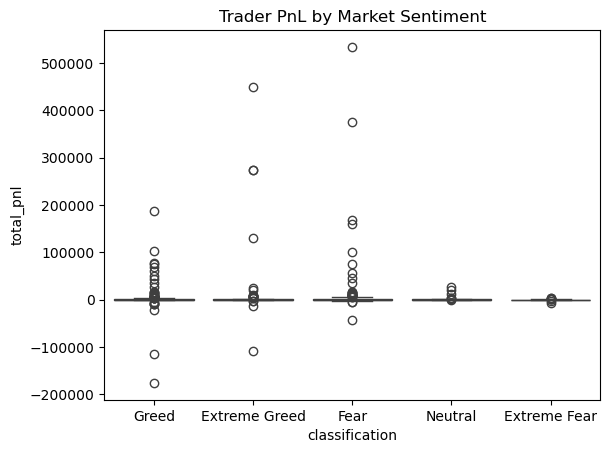

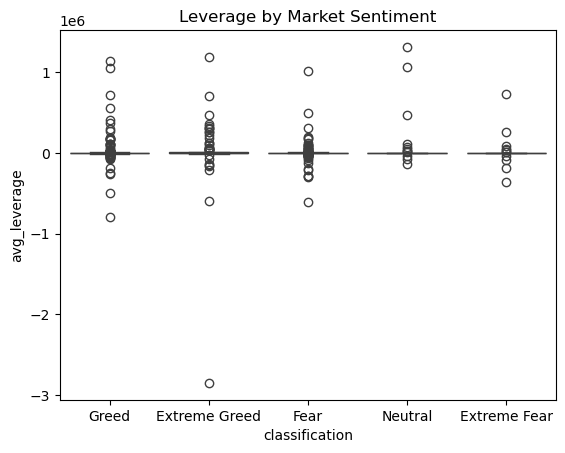

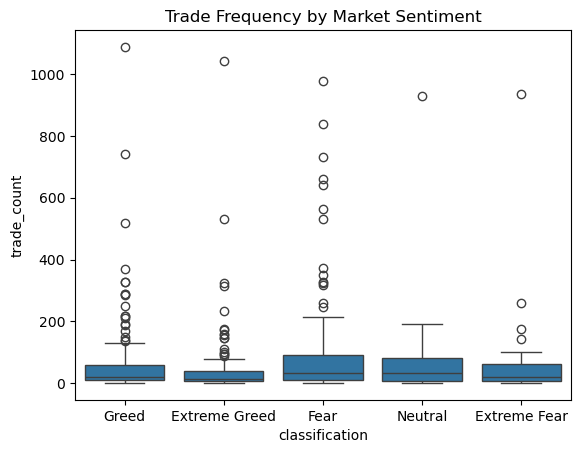

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ PnL by Sentiment
sns.boxplot(data=daily, x="classification", y="total_pnl")
plt.title("Trader PnL by Market Sentiment")
plt.savefig("outputs/pnl_by_sentiment.png", bbox_inches="tight")
plt.show()

# 2️⃣ Leverage by Sentiment
sns.boxplot(data=daily, x="classification", y="avg_leverage")
plt.title("Leverage by Market Sentiment")
plt.savefig("outputs/leverage_by_sentiment.png", bbox_inches="tight")
plt.show()

# 3️⃣ Trade Count by Sentiment
sns.boxplot(data=daily, x="classification", y="trade_count")
plt.title("Trade Frequency by Market Sentiment")
plt.savefig("outputs/trade_count_by_sentiment.png", bbox_inches="tight")
plt.show()

In [18]:
import os
print(os.getcwd())


d:\trader-sentiment-analysis\notebooks
